In [1]:
import re
import numpy as np
import pandas as pd

import tensorflow as tf

from sklearn.model_selection import train_test_split

2024-04-12 04:18:36.401180: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 04:18:37.169092: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
txt_file = 'data/kor_hiphop_text.txt'
raw_corpus = []

with open(txt_file, 'r', encoding = 'utf-8') as f:
    raw = f.read().splitlines()
    raw_corpus.extend(raw)
print(len(raw_corpus))

133715


In [3]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()                         #소문자 변경 후 양쪽 공백 제거
    sentence = re.sub(r"([?.!,¿]).,", r" \1 ", sentence)          #특수문자 양쪽에 공백 추가
    sentence = re.sub(r'[" "]+', " ", sentence)                 #여러 개의 공백이 붙어있으면 하나의 공백으로
    sentence = re.sub(r"[^a-zA-Z가-힣?!¿]+", " ", sentence)   #영어, 알파벳, ?, !, ¿ 제외 모두 공백으로
    sentence = sentence.strip()                                 #양쪽 공백 제거
    sentence = re.sub(r"\(.\)", " ", sentence)                  #괄호 제거
    sentence = '<start> ' + sentence + ' <end>'                 #start, end 추가
    return sentence

In [4]:
corpus = []
for sentence in raw_corpus:
    if len(sentence) == 0:
        continue
    if sentence[-1] == ':':
        continue
    if len(sentence)>150:
        continue

    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)

print(len(corpus))
print(corpus[:10])

128992
['<start> 다친대도 길을 걸어 kiss me <end>', '<start> 쉽지 않음 내가 쉽게 easy <end>', '<start> stage 위엔 불이 튀어 내 body <end>', '<start> pull up and i rip it up like ballet <end>', '<start> damn i really make it look easy <end>', '<start> yuh know that i make it look easy <end>', '<start> clap your hands 너도 나와 같다면 clap your hands now <end>', '<start> 의구심 따윈 그냥 치워 그냥 말해 i m the real one <end>', '<start> 조명 꺼진 뒤의 난 wander in the night <end>', '<start> don t know what is right don t know bout my rights <end>']


In [5]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = 30000, filters = ' ', oov_token = '<unk>')
    tokenizer.fit_on_texts(corpus)
    tensor = tokenizer.texts_to_sequences(corpus)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding = 'post')
    print('토크나이저: ', tokenizer, '\n', tensor)

    return tensor, tokenizer

In [6]:
tensor, tokenizer = tokenize(corpus)

토크나이저:  <keras.src.legacy.preprocessing.text.Tokenizer object at 0x7f4146cc5410> 
 [[    2 15085   196 ...     0     0     0]
 [    2  1185  8811 ...     0     0     0]
 [    2  1414  3713 ...     0     0     0]
 ...
 [    2   610     3 ...     0     0     0]
 [    2    72    22 ...     0     0     0]
 [    2    72    22 ...     0     0     0]]


In [7]:
tensor.shape

(128992, 20)

In [8]:
for idx in tokenizer.index_word:
    print(idx, ':', tokenizer.index_word[idx])
    if idx>=20: break

1 : <unk>
2 : <start>
3 : <end>
4 : i
5 : 내
6 : 난
7 : you
8 : it
9 : me
10 : the
11 : my
12 : 다
13 : 내가
14 : m
15 : 날
16 : a
17 : t
18 : yeah
19 : 더
20 : 넌


In [9]:
#소스 문장과 타겟 문장으로 1차 분리
#tensor에서 마지막 토큰을 잘라내어 소스 문장을, 첫번째 start를 잘라내어 타겟 문장을 생성
#LSTM에서 many-to-many의 답을 얻을 것이므로 위와 같이 구성
#이 과정을 통해 src_input과 tgt_input 길이 동일
src_input = tensor[:, :-1]      #start+sentence+end+padding n-1개
tgt_input = tensor[:, 1:]       #sentence+end+padding n개
print('텐서 길이: ', tensor.shape)
print('소스문장 길이: ', len(src_input[0]))
print('타겟문장 길이: ', len(tgt_input[0]))

텐서 길이:  (128992, 20)
소스문장 길이:  19
타겟문장 길이:  19


In [10]:
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size = 0.2, random_state = 1234)
print('Source Train 길이: ', enc_train.shape)
print('Target Train 길이: ', dec_train.shape)
print('Source Test 길이: ', enc_val.shape)
print('Target Test 길이: ', dec_val.shape)

Source Train 길이:  (103193, 19)
Target Train 길이:  (103193, 19)
Source Test 길이:  (25799, 19)
Target Test 길이:  (25799, 19)


In [11]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epochs = len(src_input) // BATCH_SIZE
VOCAB_SIZE = tokenizer.num_words + 1

dataset_train = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
dataset_train = dataset_train.shuffle(BUFFER_SIZE)
dataset_train = dataset_train.batch(BATCH_SIZE, drop_remainder = True)

dataset_val = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))
dataset_val = dataset_val.shuffle(BUFFER_SIZE)
dataset_val = dataset_val.batch(BATCH_SIZE, drop_remainder = True)

print(dataset_train)
print(dataset_val)

2024-04-12 04:19:02.398501: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-12 04:19:02.440219: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-12 04:19:02.440416: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

<_BatchDataset element_spec=(TensorSpec(shape=(256, 19), dtype=tf.int32, name=None), TensorSpec(shape=(256, 19), dtype=tf.int32, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(256, 19), dtype=tf.int32, name=None), TensorSpec(shape=(256, 19), dtype=tf.int32, name=None))>


L355
2024-04-12 04:19:02.441567: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-12 04:19:02.441663: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-12 04:19:03.617338: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#

In [12]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)      #vocab_size로 입력되어서 그걸 embedding_size 만큼으로 표현할 것
        self.rnn_1 = tf.keras.layers.SimpleRNN(hidden_size, return_sequences = True)
        self.rnn_2 = tf.keras.layers.SimpleRNN(hidden_size, return_sequences = True)
        self.linear = tf.keras.layers.Dense(vocab_size)     #vocab_size로 줄여야 다음에 무슨 단어를 낼지에 대한 각 클래스 별 수치가 출력

    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)

        return out

In [13]:
embedding_size = 256    #word embedding 차원 수. 즉, 단어가 추상적으로 표현되는 크기
hidden_size = 1024      #hidden state의 차원 수
model = TextGenerator(tokenizer.num_words + 1, embedding_size, hidden_size)
model

<TextGenerator name=text_generator, built=False>

In [14]:
for src_sample, tgt_sample in dataset_train.take(1): break
model(src_sample)

<tf.Tensor: shape=(256, 19, 30001), dtype=float32, numpy=
array([[[ 1.22321094e-03,  9.88429319e-03, -2.04938021e-03, ...,
         -6.35950873e-03,  7.70551735e-04, -4.27012012e-04],
        [ 2.56216084e-03, -2.66078999e-03,  3.32197943e-03, ...,
          1.01922620e-02,  2.52912915e-03, -9.80327278e-03],
        [-9.92988329e-03, -1.52570680e-02,  9.81584750e-03, ...,
          1.40014170e-02, -6.90927170e-03, -3.91701609e-03],
        ...,
        [ 3.82722355e-05, -3.76801565e-03, -3.53604443e-02, ...,
          1.59149822e-02,  1.22088445e-02, -3.63422036e-02],
        [-2.01791245e-02,  1.25353917e-01, -3.01229209e-02, ...,
          5.21525070e-02,  7.36239702e-02, -3.72765139e-02],
        [-4.89481874e-02, -9.07193869e-03,  2.38022860e-02, ...,
          8.23110491e-02,  7.30869696e-02,  2.14470476e-02]],

       [[ 1.22321094e-03,  9.88429319e-03, -2.04938021e-03, ...,
         -6.35950873e-03,  7.70551735e-04, -4.27012012e-04],
        [-2.43163179e-03, -1.31143089e-02,  1

In [15]:
model.summary()

Model: "text_generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     7,680,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ ?                      │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │    30,751,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,841,201 (159.61 MB)

 Trainable params: 41,841,201 (159.61 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [17]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = 'none')

In [18]:
model.compile(loss = loss, optimizer = optimizer)
model.fit(dataset_train, epochs = 10)

Epoch 1/10


I0000 00:00:1712895566.800547  507781 service.cc:145] XLA service 0x324d1b10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1712895566.800582  507781 service.cc:153]   StreamExecutor device (0): NVIDIA A16-16Q, Compute Capability 8.6
2024-04-12 04:19:26.844791: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-12 04:19:27.320242: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1712895569.183415  507856 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_63', 1748 bytes spill stores, 2168 bytes spill loads

I0000 00:00:1712895569.450320  507855 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_61', 1740 bytes spill stores, 2152 bytes spill loads

I0000 00:00:1712895

403/403 ━━━━━━━━━━━━━━━━━━━━ 111s 254ms/step - loss: 2.5472
Epoch 2/10
403/403 ━━━━━━━━━━━━━━━━━━━━ 103s 255ms/step - loss: 1.8653
Epoch 3/10
403/403 ━━━━━━━━━━━━━━━━━━━━ 103s 255ms/step - loss: 1.7701
Epoch 4/10
403/403 ━━━━━━━━━━━━━━━━━━━━ 103s 255ms/step - loss: 1.6772
Epoch 5/10
403/403 ━━━━━━━━━━━━━━━━━━━━ 103s 255ms/step - loss: 1.5909
Epoch 6/10
403/403 ━━━━━━━━━━━━━━━━━━━━ 103s 255ms/step - loss: 1.5081
Epoch 7/10
403/403 ━━━━━━━━━━━━━━━━━━━━ 103s 255ms/step - loss: 1.4453
Epoch 8/10
403/403 ━━━━━━━━━━━━━━━━━━━━ 103s 255ms/step - loss: 1.3654
Epoch 9/10
403/403 ━━━━━━━━━━━━━━━━━━━━ 103s 255ms/step - loss: 1.2863
Epoch 10/10
403/403 ━━━━━━━━━━━━━━━━━━━━ 103s 255ms/step - loss: 1.2139


In [19]:
model.save('rnn_kor_hiphop.keras')
model.save('rnn_kor_hiphop.h5')
tf.saved_model.save(model, 'rnn_kor_hiphop.tf')

INFO:tensorflow:Assets written to: rnn_kor_hiphop.tf/assets


INFO:tensorflow:Assets written to: rnn_kor_hiphop.tf/assets


In [20]:
def generate_text(model, tokenizer, init_sentence = '<start>', max_len = 30):
    #테스트를 위해 입력받은 init_sentence도 텐서 변환
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype = tf.int64)
    end_token = tokenizer.word_index['<end>']

    #단어를 하나씩 예측해 문장 생성
    while True:
        #1. 입력받은 문장의 텐서 입력
        predict = model(test_tensor)
        #2. 예측된 값 중 가장 높은 확률인 word index를 출력
        predict_word = tf.argmax(tf.nn.softmax(predict, axis = -1), axis = -1)[:, -1]
        #3. 2에서 예측된 word index를 문장 뒤에 붙임
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis = 0)], axis = -1)
        #4. 모델이 <end>를 예측했거나 max_len에 도달하면 문장 생성을 마침
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ''
    #tokenizer를 활용해 word index를 단어로 하나씩 변환
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + ' '

    return generated

In [21]:
generate_text(model, tokenizer, init_sentence = '<start> i')

'<start> i m a different type of beast <end> '

In [22]:
generate_text(model, tokenizer, init_sentence = '<start> 나')

'<start> 나 지금 취했어 <end> '

In [23]:
generate_text(model, tokenizer, init_sentence = '<start> 나', max_len = 50)

'<start> 나 지금 취했어 <end> '

In [24]:
generate_text(model, tokenizer, init_sentence = '<start> 사랑해')

'<start> 사랑해 사랑해 <end> '

In [25]:
generate_text(model, tokenizer, init_sentence = '<start> 사랑은')

'<start> 사랑은 <unk> <end> '

In [26]:
generate_text(model, tokenizer, init_sentence = '<start> 사랑이')

'<start> 사랑이 <unk> <end> '

hiphop_little girl - 신준수  
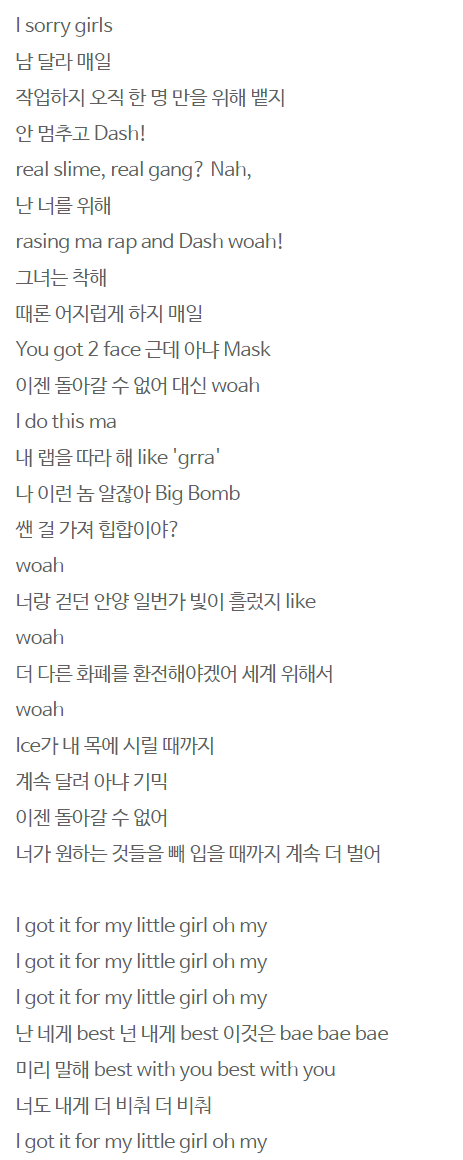

In [29]:
little_girl = ['i', '남', '작업', '안', 'real', '난', '그녀는', '랩', '쌘', '너랑', '더', 'ice', '계속', '이젠', '너가']
for word in little_girl:
    word = '<start> ' + word
    print(generate_text(model, tokenizer, init_sentence = word))

<start> i m a different type of beast <end> 
<start> 남 <unk> <unk> <end> 
<start> 작업 오는 장면만 기른 <end> 
<start> 안 들려 난 이대론 <end> 
<start> real love <end> 
<start> 난 <unk> <unk> <end> 
<start> 그녀는 <unk> <end> 
<start> 랩 <unk> <unk> <unk> <end> 
<start> <unk> <unk> <end> 
<start> 너랑 달라 <end> 
<start> 더 <unk> <end> 
<start> ice freeze the moon <end> 
<start> 계속 <unk> <end> 
<start> 이젠 <unk> <unk> <end> 
<start> 너가 보고 싶은 건 어쩌면 <end> 


all genre_임수-goood  
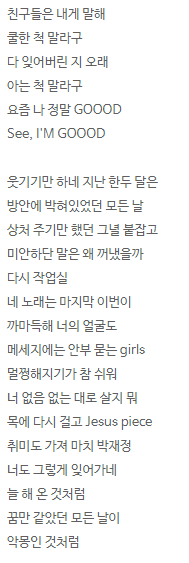

In [30]:
goood = ['친구들은', '쿨한', '다', '아는', '요즘', 'see', '웃기기만', '방안에', '상처', '미안하단']
for word in goood:
    word = '<start> ' + word
    print(generate_text(model, tokenizer, init_sentence = word))

<start> 친구들은 <unk> <end> 
<start> 쿨한 시간 없어 <end> 
<start> 다 <unk> <unk> <end> 
<start> 아는 <unk> 즐기면서 <end> 
<start> 요즘 <unk> <unk> <end> 
<start> see me why <end> 
<start> <unk> <unk> <end> 


<start> 방안에 <unk> <end> 
<start> 상처 <unk> <end> 
<start> 미안하단 말은 아냐 사랑했거든 <end> 


: 